In [3]:
import jax

from tools import generate_data
from jax import random, jit
import jax.numpy as jnp
import equinox as eqx
from jaxtyping import Float, Array, PRNGKeyArray, PyTree
from typing import Callable
from optax import squared_error
import optax

In [4]:
%load_ext jaxtyping
%jaxtyping.typechecker typeguard.typechecked

In [5]:
FloatScalar = Float[Array, ""]
key = random.key(1234)

2024-08-26 19:06:47.077605: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
key, x, y = generate_data(key, (1000,), -1000, 1000, lambda x: 3 * jnp.pow(x, 3) + 2 * jnp.pow(x, 2) + x * 0.5 + 10,
                          -100,
                          100)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
x[0]

Array([-1026.215], dtype=float32)

In [7]:
print(x.shape, y.shape)

(1000, 1) (1000, 1)


In [8]:
class ZScoreNormalizer(eqx.Module):
    mean: Float[Array, "feature_size"]
    std: Float[Array, "feature_size"]

    def __init__(self, x_train: Float[Array, "batch_size feature_size"], axis: int = 0):
        self.mean = x_train.mean(axis)
        self.std = x_train.std(axis)

    @jit
    def __call__(self, x: Float[Array, "feature_size"]) -> Float[Array, "feature_size"]:
        return (x - self.mean) / self.std

In [9]:
_norm = ZScoreNormalizer(x)
print(_norm(x[100]))
print(x[100])

[-1.1722205]
[-720.9978]


In [10]:
class Model(eqx.Module):
    layers: list[Callable]

    def __init__(self, x: Float[Array, "batch_size feature_size"], *, key: PRNGKeyArray):
        key1, key2 = random.split(key, 2)
        self.layers = [
            ZScoreNormalizer(x),
            eqx.nn.Linear(1, 10, key=key1),
            jax.nn.relu,
            eqx.nn.Linear(10, 1, key=key2),
        ]

    def __call__(self, x: Float[Array, "feature_size"]) -> Float[Array, "1"]:
        for layer in self.layers:
            x = layer(x)
        return x


In [11]:
key, subkey = random.split(key)
model = Model(x, key=subkey)

In [21]:
print(model)

Model(
  layers=[
    ZScoreNormalizer(mean=f32[1], std=f32[1]),
    Linear(
      weight=f32[10,1],
      bias=f32[10],
      in_features=1,
      out_features=10,
      use_bias=True
    ),
    <wrapped function relu>,
    Linear(
      weight=f32[1,10],
      bias=f32[1],
      in_features=10,
      out_features=1,
      use_bias=True
    )
  ]
)


In [13]:
@eqx.filter_jit
def loss(model: Model, x: Float[Array, "batch_size feature_size"], y: Float[Array, "batch_size 1"]) -> FloatScalar:
    y_pred = jax.vmap(model)(x)
    return jnp.mean(squared_error(y_pred, y))

In [14]:
loss_value = loss(model, x, y)
print(f"Loss: {loss_value}")

Loss: 1.3573165930418012e+18


In [15]:
@eqx.filter_jit
def accuracy(model: Model, x: Float[Array, "batch_size feature_size"], y: Float[Array, "batch_size 1"]) -> FloatScalar:
    y_pred = jax.vmap(model)(x)
    return jnp.mean(jnp.abs(y_pred - y))


def evaluation(model: Model, x: Float[Array, "batch_size feature_size"], y: Float[Array, "batch_size 1"]) -> tuple[
    FloatScalar, FloatScalar]:
    return loss(model, x, y), accuracy(model, x, y)

In [16]:
evaluation(model, x, y)

(Array(1.3573166e+18, dtype=float32), Array(7.8228506e+08, dtype=float32))

In [19]:
optimizer = optax.adam(10)


@eqx.filter_jit
def train_step(model: Model, opt_state: PyTree, x: Float[Array, "batch_size feature_size"],
               y: Float[Array, "batch_size 1"]) -> tuple[Model, PyTree, FloatScalar]:
    loss_value, grad = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = optimizer.update(grad, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


def train(model: Model, x: Float[Array, "batch_size feature_size"], y: Float[Array, "batch_size 1"],
          epoches: int) -> Model:
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    for _ in range(epoches):
        model, opt_state, loss_value = train_step(model, opt_state, x, y)
    return model

In [20]:
model = train(model, x, y, 100000)

TypeError: 'NoneType' object is not callable

In [35]:
evaluation(model, x, y)

(Array(4.4534744e+16, dtype=float32), Array(1.3860984e+08, dtype=float32))

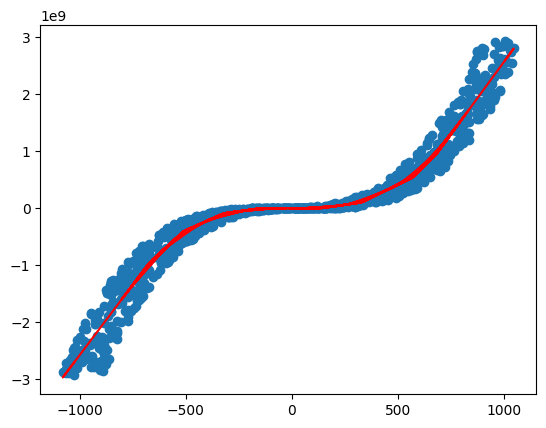

In [36]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.plot(x, jax.vmap(model)(x), color="red")